<a href="https://colab.research.google.com/github/2bahaa/Plant-Disease-Detection/blob/main/Potato_disease(99_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img, save_img
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# Define the path to the existing dataset folder (adjust this as necessary)
data_directory = '/content/drive/MyDrive/dataset/Potato Disease dataset'

# Check if the directory exists
if os.path.exists(data_directory):
    print(f"Dataset directory found: {data_directory}")
else:
    print("Dataset directory not found. Please check the path.")

healthy_dir = os.path.join(data_directory, '/content/drive/MyDrive/dataset/Potato Disease dataset/Potato_healthy')  # Path to the 'healthy' images folder
augmented_dir = os.path.join(data_directory, '/content/drive/MyDrive/dataset/augmented_healthy')  # Path for storing augmented images

# Ensure the augmented directory exists
os.makedirs(augmented_dir, exist_ok=True)


# Data augmentation for the 'healthy' class
healthy_datagen = ImageDataGenerator(
    horizontal_flip=True,         # Random horizontal flips
    vertical_flip=True,           # Random vertical flips
    zoom_range=0.2,               # Random zoom
    brightness_range=[0.5, 1.5],  # Random brightness adjustments
    fill_mode='nearest'           # Fill empty pixels with nearest neighbors
)

# Load and augment images
healthy_images = os.listdir(healthy_dir)
target_size = (224, 224)  # Image size to resize
current_count = len(healthy_images)  # Current number of healthy images
required_augmentations = 1000 - current_count  # Number of images needed to reach 1000

print(f"Augmenting {required_augmentations} images...")

# Loop through images and augment them
for img_name in tqdm(healthy_images, desc="Augmenting Healthy Images"):
    img_path = os.path.join(healthy_dir, img_name)
    img = load_img(img_path, target_size=target_size)  # Load and resize image
    img_array = img_to_array(img)                     # Convert to NumPy array
    img_array = np.expand_dims(img_array, axis=0)     # Add batch dimension

    # Generate augmented images
    aug_iter = healthy_datagen.flow(img_array, batch_size=1)
    for i in range(required_augmentations // len(healthy_images) + 1):  # Repeat augmentations as needed
        aug_img = next(aug_iter)[0].astype('uint8')  # Generate one augmented image
        save_path = os.path.join(augmented_dir, f"aug_{img_name.split('.')[0]}_{i}.jpg")
        save_img(save_path, aug_img)

# Move augmented images back to the main healthy class directory
augmented_images = os.listdir(augmented_dir)
for aug_img in augmented_images:
    shutil.move(os.path.join(augmented_dir, aug_img), os.path.join(healthy_dir, aug_img))

print(f"Healthy class now contains {len(os.listdir(healthy_dir))} images.")

Dataset directory found: /content/drive/MyDrive/dataset/Potato Disease dataset
Augmenting -64 images...


Augmenting Healthy Images: 100%|██████████| 1064/1064 [01:02<00:00, 16.96it/s] 


Healthy class now contains 1064 images.


In [ ]:

# Create ImageDataGenerator instances with preprocessing function and data splits
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3,
)

# Training generator (60% of data)
train_generator = datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),                 # Resizes images to 224x224 pixels to fit MobileNetV2 input shape
    batch_size=32,                          # Number of images in each batch
    class_mode='categorical',               # Sets labels in categorical format (for multiclass classification)
    shuffle=True,                           # Shuffles the data for each epoch
    subset='training'                       # Use this for training data (70%)
)

# Validation generator (20% of data)
validation_generator = datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,       # Keeps the validation data order for consistent results
    subset='validation'  # Use this for validation data
)

# Test generator (10% of data)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1  # Specifically reserves 10% for testing
)

test_generator = test_datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # Use this for test data
)
# Step 4: Verify Splits
print("Training Set:", train_generator.samples)
print("Validation Set:", validation_generator.samples)
print("Test Set:", test_generator.samples)

Found 2145 images belonging to 3 classes.
Found 919 images belonging to 3 classes.
Found 306 images belonging to 3 classes.
Training Set: 2145
Validation Set: 919
Test Set: 306


In [ ]:
# Step 4: Build the Model with Transfer Learning
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Step 5: Train the Model
EPOCHS = 30
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    #callbacks=[early_stopping, lr_scheduler],
)
# Evaluate the model on validation and test sets
val_loss, val_accuracy = model.evaluate(validation_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accuracy: 0.7072 - loss: 0.7459 - val_accuracy: 0.9728 - val_loss: 0.0860
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.9393 - loss: 0.1468 - val_accuracy: 0.9728 - val_loss: 0.0788
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9624 - loss: 0.1141 - val_accuracy: 0.9826 - val_loss: 0.0551
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9628 - loss: 0.0906 - val_accuracy: 0.9695 - val_loss: 0.0780
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.9712 - loss: 0.0784 - val_accuracy: 0.9848 - val_loss: 0.0425
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.9681 - loss: 0.0873 - val_accuracy: 0.9771 - val_loss: 0.0662
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9745 - loss: 0.0719 - val_accuracy: 0.9728 - val_loss: 0.0610
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9783 - loss: 0.0582 - val_accuracy: 0.9826 - val_loss: 0.

In [ ]:

#  Predictions and Metrics Calculation
# Get predictions from the validation generator
validation_generator.reset()  # Reset generator to start from the beginning
predictions = model.predict(validation_generator)    # Generates predictions for validation set
predicted_classes = np.argmax(predictions, axis=1)   # Converts probabilities to class labels

# True classes from the generator
true_classes = validation_generator.classes         # Actual labels from validation set
class_labels = list(validation_generator.class_indices.keys())  # Gets class names

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step


In [ ]:
#  Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      0.98      0.99       300
 Potato___Late_blight       0.97      0.98      0.98       300
       Potato_healthy       0.98      0.99      0.99       319

             accuracy                           0.98       919
            macro avg       0.98      0.98      0.98       919
         weighted avg       0.98      0.98      0.98       919



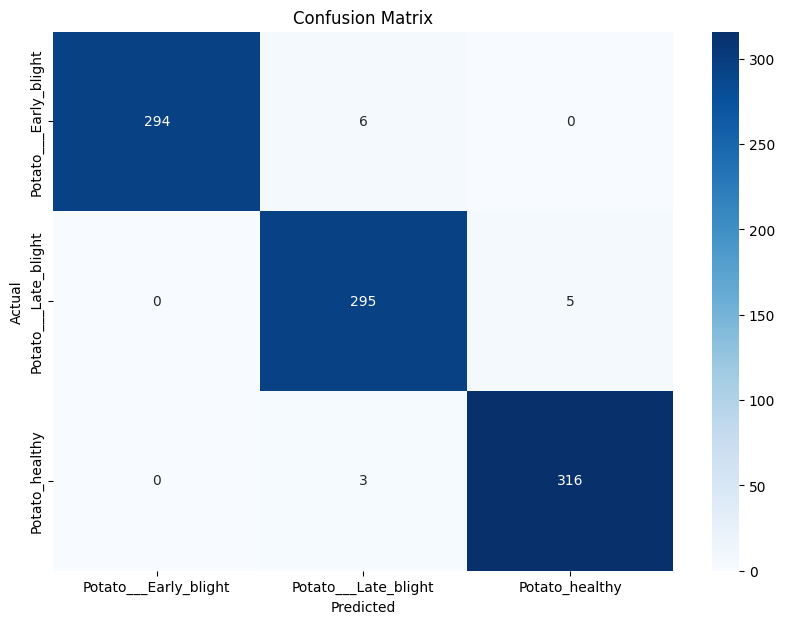

In [ ]:
#  Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

F1 Score: 0.9848


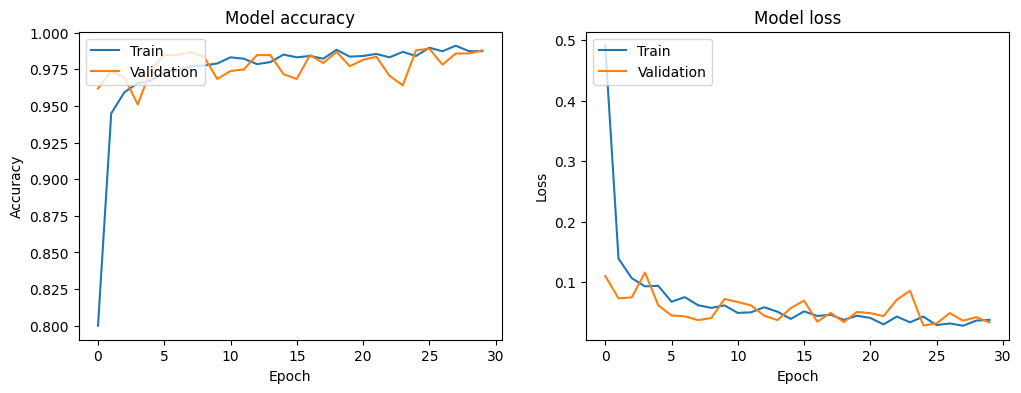

In [ ]:
#  Additional Metrics
from sklearn.metrics import f1_score

f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

#  plot the training and validation loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step


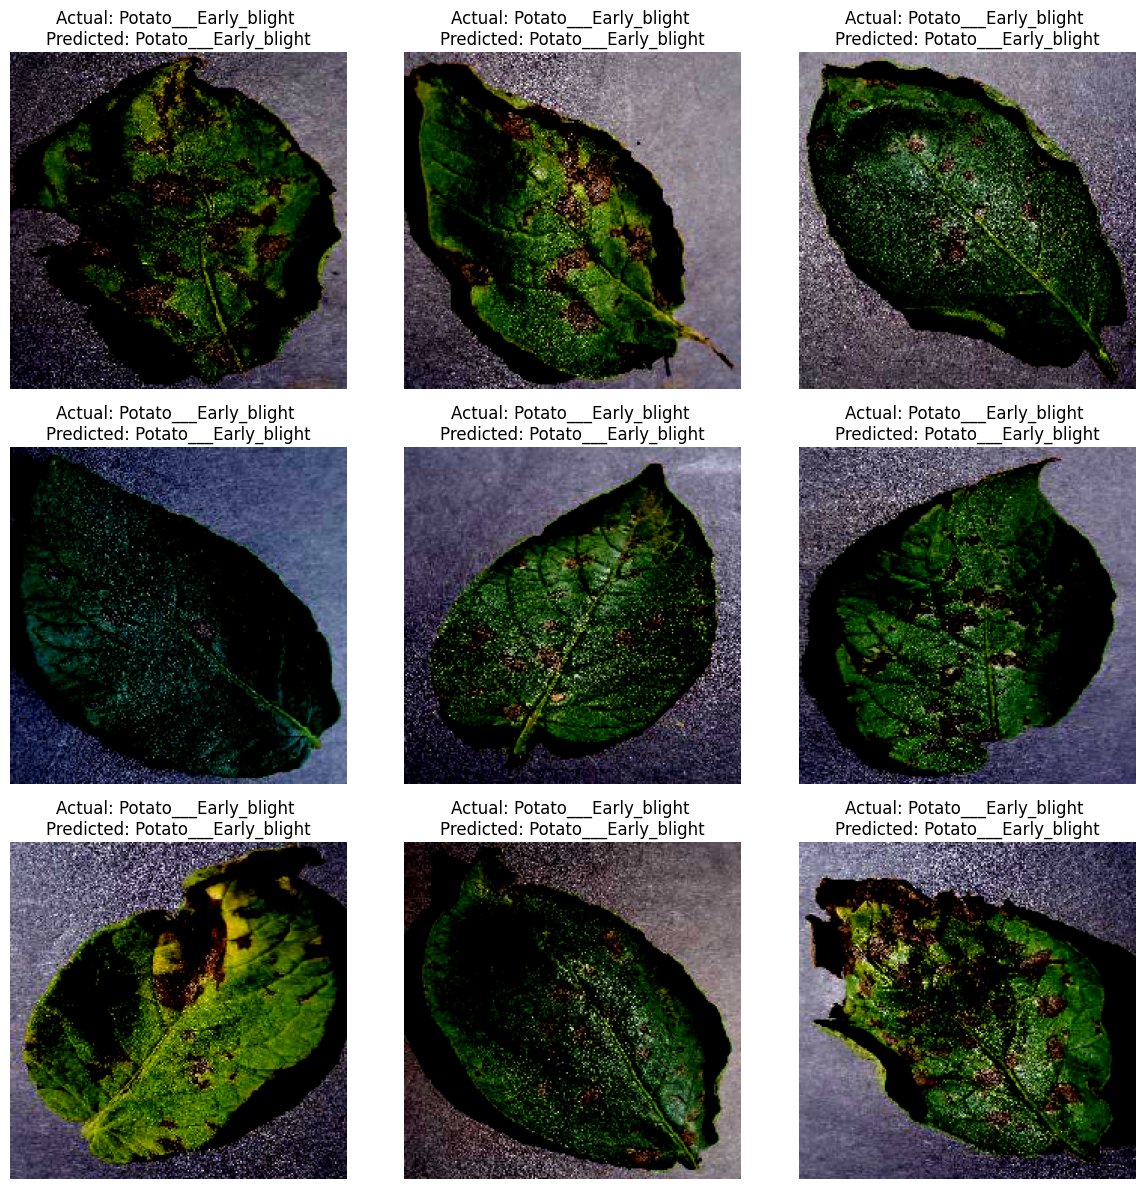

In [ ]:
# Reset the test generator to start from the beginning
test_generator.reset()  # Resets the generator for consistent test results

# Step 1: Get predictions and actual labels
predictions = model.predict(test_generator)               # Predictions for test data
predicted_classes = np.argmax(predictions, axis=1)        # Maps probabilities to predicted labels
true_classes = test_generator.classes                     # Actual labels from test set
class_labels = list(test_generator.class_indices.keys())  # List of class labels

# Step 2: Select a batch of test images for displaying
batch = next(test_generator)  # Gets the next batch of images and labels
images, labels = batch[0], batch[1]  # Separates images and their true labels

# Step 3: Plot images with actual and predicted labels
plt.figure(figsize=(12, 12))       # Sets up the plot figure size
for i in range(9):                 # Display first 9 images
    ax = plt.subplot(3, 3, i + 1)  # Arrange images in a 3x3 grid
    image = images[i]
    true_label = class_labels[np.argmax(labels[i])]       # Get true class label for each image
    predicted_label = class_labels[predicted_classes[i]]  # Predicted class label

    plt.imshow(image)  # Display the image
    plt.title(f"Actual: {true_label} \nPredicted: {predicted_label}")  # Shows true vs predicted label
    plt.axis("off")  # Hides axes

plt.tight_layout()  # Adjusts layout to avoid overlap
plt.show()  # Display the plot

In [ ]:
model.save('/content/drive/MyDrive/Potato_model.h5')

In [ ]:
!ls /content/drive/MyDrive/Potato_model